In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ Libraries loaded")

✅ Libraries loaded


In [10]:
# Configuration
BASE_DIR = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
MODEL_DIR = BASE_DIR / "models" / "xgboost_walkforward"
RESULTS_DIR = BASE_DIR / "results" / "realistic_backtest"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

ASSETS = [
    "AAPL", "NVDA", "TSLA", "MSFT", "GOOGL", "AMZN", "META",
    "SPY", "QQQ", "EFA", "IEF", "HYG", "BIL", "INTC", "AMD"
]

# REALISTIC PARAMETERS
CONFIG = {
    'initial_capital': 1_000_000,
    'transaction_cost': 0.005,    # 0.5% realistic for large trades
    'slippage': 0.002,            # 0.2% market impact
    'rebalance_days': 5,          # Match prediction horizon
    'max_position': 0.20,         # Max 20% in any asset
    'test_start': '2021-01-01',   # TRUE out-of-sample only
    'test_end': '2024-11-25',
}

print(f"📂 Model directory: {MODEL_DIR}")
print(f"📂 Results directory: {RESULTS_DIR}")
print(f"\n⚙️ Backtest Configuration:")
for k, v in CONFIG.items():
    print(f"   {k}: {v}")

📂 Model directory: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost_walkforward
📂 Results directory: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\results\realistic_backtest

⚙️ Backtest Configuration:
   initial_capital: 1000000
   transaction_cost: 0.005
   slippage: 0.002
   rebalance_days: 5
   max_position: 0.2
   test_start: 2021-01-01
   test_end: 2024-11-25


## 1. Load ACTUAL Price Data from Yahoo Finance

We need real prices to calculate true returns, not the model's targets.

In [11]:
def load_real_prices(assets, start_date, end_date):
    """Download actual historical prices from Yahoo Finance."""
    print("📥 Downloading real price data from Yahoo Finance...")
    
    prices = {}
    for asset in assets:
        try:
            ticker = yf.Ticker(asset)
            hist = ticker.history(start=start_date, end=end_date)
            if len(hist) > 0:
                prices[asset] = hist['Close']
                print(f"  ✅ {asset}: {len(hist)} days")
            else:
                print(f"  ❌ {asset}: No data")
        except Exception as e:
            print(f"  ❌ {asset}: {e}")
    
    # Combine into DataFrame
    price_df = pd.DataFrame(prices)
    price_df = price_df.dropna()
    
    print(f"\n📊 Price data: {len(price_df)} trading days")
    print(f"📅 Date range: {price_df.index.min().date()} to {price_df.index.max().date()}")
    
    return price_df

# Load real prices
prices_df = load_real_prices(ASSETS, CONFIG['test_start'], CONFIG['test_end'])

# Calculate daily returns
returns_df = prices_df.pct_change().dropna()
print(f"\n📈 Daily returns calculated: {len(returns_df)} days")

📥 Downloading real price data from Yahoo Finance...
  ✅ AAPL: 980 days
  ✅ NVDA: 980 days
  ✅ TSLA: 980 days
  ✅ MSFT: 980 days
  ✅ GOOGL: 980 days
  ✅ AMZN: 980 days
  ✅ META: 980 days
  ✅ SPY: 980 days
  ✅ QQQ: 980 days
  ✅ EFA: 980 days
  ✅ IEF: 980 days
  ✅ HYG: 980 days
  ✅ BIL: 980 days
  ✅ INTC: 980 days
  ✅ AMD: 980 days

📊 Price data: 980 trading days
📅 Date range: 2021-01-04 to 2024-11-22

📈 Daily returns calculated: 979 days


In [12]:
# Verify against real-world performance
print("\n" + "="*60)
print("REAL STOCK PERFORMANCE (2021-2024)")
print("="*60)

for asset in ASSETS:
    if asset in prices_df.columns:
        total_ret = (prices_df[asset].iloc[-1] / prices_df[asset].iloc[0]) - 1
        n_years = (prices_df.index[-1] - prices_df.index[0]).days / 365.25
        annual_ret = (1 + total_ret) ** (1/n_years) - 1
        print(f"{asset:6s}: Total={total_ret*100:+7.1f}%  Annual={annual_ret*100:+6.1f}%")

# Portfolio average (equal weight)
eq_weight_ret = returns_df.mean(axis=1)
eq_total = (1 + eq_weight_ret).prod() - 1
eq_annual = (1 + eq_total) ** (1/n_years) - 1
print(f"\n{'EQ WEIGHT':6s}: Total={eq_total*100:+7.1f}%  Annual={eq_annual*100:+6.1f}%")


REAL STOCK PERFORMANCE (2021-2024)
AAPL  : Total=  +81.7%  Annual= +16.6%
NVDA  : Total= +985.1%  Annual= +84.8%
TSLA  : Total=  +44.9%  Annual= +10.0%
MSFT  : Total=  +98.2%  Annual= +19.3%
GOOGL : Total=  +91.4%  Annual= +18.2%
AMZN  : Total=  +23.7%  Annual=  +5.6%
META  : Total= +108.5%  Annual= +20.8%
SPY   : Total=  +70.4%  Annual= +14.7%
QQQ   : Total=  +67.4%  Annual= +14.2%
EFA   : Total=  +17.7%  Annual=  +4.3%
IEF   : Total=  -15.0%  Annual=  -4.1%
HYG   : Total=  +11.6%  Annual=  +2.9%
BIL   : Total=  +11.3%  Annual=  +2.8%
INTC  : Total=  -45.4%  Annual= -14.4%
AMD   : Total=  +49.9%  Annual= +11.0%

EQ WEIGHT: Total=  +78.4%  Annual= +16.1%


## 2. Load Model Predictions (TRUE Out-of-Sample Only)

In [13]:
def load_oos_predictions(assets, model_dir, start_date):
    """Load OOS predictions, filtering to TRUE out-of-sample period only."""
    predictions = {}
    
    start_dt = pd.Timestamp(start_date)
    
    for asset in assets:
        oos_path = model_dir / f"{asset}_oos_predictions.csv"
        if oos_path.exists():
            df = pd.read_csv(oos_path, index_col=0, parse_dates=True)
            # Filter to TRUE out-of-sample only (2021+)
            df = df[df.index >= start_dt]
            if len(df) > 0:
                predictions[asset] = df['pred']
                print(f"  ✅ {asset}: {len(df)} predictions (from {df.index.min().date()})")
    
    pred_df = pd.DataFrame(predictions)
    pred_df = pred_df.dropna()
    
    print(f"\n📊 Predictions: {len(pred_df)} days")
    return pred_df

print("📥 Loading model predictions (2021+ only)...")
predictions_df = load_oos_predictions(ASSETS, MODEL_DIR, CONFIG['test_start'])

📥 Loading model predictions (2021+ only)...
  ✅ AAPL: 981 predictions (from 2021-01-04)
  ✅ NVDA: 981 predictions (from 2021-01-04)
  ✅ TSLA: 981 predictions (from 2021-01-04)
  ✅ MSFT: 981 predictions (from 2021-01-04)
  ✅ GOOGL: 981 predictions (from 2021-01-04)
  ✅ AMZN: 981 predictions (from 2021-01-04)
  ✅ META: 981 predictions (from 2021-01-04)
  ✅ SPY: 981 predictions (from 2021-01-04)
  ✅ QQQ: 981 predictions (from 2021-01-04)
  ✅ EFA: 981 predictions (from 2021-01-04)
  ✅ IEF: 981 predictions (from 2021-01-04)
  ✅ HYG: 981 predictions (from 2021-01-04)
  ✅ BIL: 981 predictions (from 2021-01-04)
  ✅ INTC: 981 predictions (from 2021-01-04)
  ✅ AMD: 981 predictions (from 2021-01-04)

📊 Predictions: 981 days


In [17]:
# Normalize both indices - remove timezone from returns
predictions_df.index = pd.to_datetime(predictions_df.index).normalize()

# Critical fix: remove timezone from returns_df
if returns_df.index.tz is not None:
    returns_df.index = returns_df.index.tz_localize(None)
returns_df.index = returns_df.index.normalize()

print("After full normalization:")
print("Predictions index[:3]:", predictions_df.index[:3].tolist())
print("Returns index[:3]:", returns_df.index[:3].tolist())

# Align predictions with actual returns
common_dates = predictions_df.index.intersection(returns_df.index)
predictions_aligned = predictions_df.loc[common_dates].copy()
returns_aligned = returns_df.loc[common_dates].copy()

print(f"\n📊 Aligned data: {len(common_dates)} trading days")
if len(common_dates) > 0:
    print(f"📅 Period: {common_dates.min().date()} to {common_dates.max().date()}")
else:
    print("⚠️ Date formats don't match!")

After full normalization:
Predictions index[:3]: [Timestamp('2021-01-04 00:00:00'), Timestamp('2021-01-05 00:00:00'), Timestamp('2021-01-06 00:00:00')]
Returns index[:3]: [Timestamp('2021-01-05 00:00:00'), Timestamp('2021-01-06 00:00:00'), Timestamp('2021-01-07 00:00:00')]

📊 Aligned data: 979 trading days
📅 Period: 2021-01-05 to 2024-11-22


In [15]:
# Align predictions with actual returns
common_dates = predictions_df.index.intersection(returns_df.index)
predictions_aligned = predictions_df.loc[common_dates]
returns_aligned = returns_df.loc[common_dates]

print(f"📊 Aligned data: {len(common_dates)} trading days")
print(f"📅 Period: {common_dates.min().date()} to {common_dates.max().date()}")

📊 Aligned data: 0 trading days


AttributeError: 'float' object has no attribute 'date'

## 3. Realistic Backtest Engine

In [18]:
class RealisticBacktest:
    """
    Realistic portfolio backtest with:
    - Proper rebalancing frequency (every N days)
    - Transaction costs
    - Slippage
    - Position limits
    """
    
    def __init__(self, returns, predictions, config):
        self.returns = returns
        self.predictions = predictions
        self.config = config
        self.n_assets = len(returns.columns)
        self.assets = list(returns.columns)
        
    def signal_to_weights(self, signals):
        """Convert prediction signals to portfolio weights."""
        # Normalize predictions to weights
        # Higher prediction = higher weight
        signals = np.array(signals)
        
        # Shift to positive and normalize
        shifted = signals - signals.min() + 0.01
        weights = shifted / shifted.sum()
        
        # Apply position limits
        weights = np.clip(weights, 0, self.config['max_position'])
        weights = weights / weights.sum()  # Renormalize
        
        return weights
    
    def run_backtest(self, strategy='signal'):
        """
        Run backtest with specified strategy.
        
        strategy: 'signal' (use predictions) or 'equal' (equal weight)
        """
        dates = self.returns.index
        n_days = len(dates)
        rebal_freq = self.config['rebalance_days']
        
        # Initialize
        portfolio_value = self.config['initial_capital']
        weights = np.ones(self.n_assets) / self.n_assets  # Start equal
        
        # Track history
        history = {
            'date': [],
            'portfolio_value': [],
            'weights': [],
            'turnover': [],
            'costs': []
        }
        
        for i, date in enumerate(dates):
            # Get today's returns
            daily_returns = self.returns.loc[date].values
            
            # Calculate portfolio return (before rebalancing)
            port_return = np.dot(weights, daily_returns)
            portfolio_value *= (1 + port_return)
            
            # Rebalance every N days
            turnover = 0
            costs = 0
            
            if i % rebal_freq == 0 and i > 0:
                if strategy == 'signal' and date in self.predictions.index:
                    signals = self.predictions.loc[date].values
                    new_weights = self.signal_to_weights(signals)
                else:
                    new_weights = np.ones(self.n_assets) / self.n_assets
                
                # Calculate turnover
                turnover = np.sum(np.abs(new_weights - weights))
                
                # Apply transaction costs and slippage
                total_cost_rate = self.config['transaction_cost'] + self.config['slippage']
                costs = turnover * total_cost_rate * portfolio_value
                portfolio_value -= costs
                
                weights = new_weights
            
            # Record
            history['date'].append(date)
            history['portfolio_value'].append(portfolio_value)
            history['weights'].append(weights.copy())
            history['turnover'].append(turnover)
            history['costs'].append(costs)
        
        return pd.DataFrame(history).set_index('date')
    
    def calculate_metrics(self, results):
        """Calculate performance metrics."""
        values = results['portfolio_value'].values
        returns = np.diff(values) / values[:-1]
        
        total_return = (values[-1] / values[0]) - 1
        n_years = len(values) / 252
        annual_return = (1 + total_return) ** (1/n_years) - 1
        annual_vol = np.std(returns) * np.sqrt(252)
        sharpe = (annual_return - 0.02) / annual_vol if annual_vol > 0 else 0
        
        # Max drawdown
        peak = np.maximum.accumulate(values)
        drawdown = (peak - values) / peak
        max_dd = np.max(drawdown)
        
        # Total costs
        total_costs = results['costs'].sum()
        
        return {
            'total_return': total_return,
            'annual_return': annual_return,
            'annual_volatility': annual_vol,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_dd,
            'total_costs': total_costs,
            'final_value': values[-1]
        }

print("✅ RealisticBacktest class defined")

✅ RealisticBacktest class defined


## 4. Run Backtests

In [19]:
# Initialize backtest engine
backtest = RealisticBacktest(returns_aligned, predictions_aligned, CONFIG)

# Run signal-based strategy
print("🚀 Running signal-based backtest...")
signal_results = backtest.run_backtest(strategy='signal')
signal_metrics = backtest.calculate_metrics(signal_results)

# Run equal-weight benchmark
print("🚀 Running equal-weight benchmark...")
equal_results = backtest.run_backtest(strategy='equal')
equal_metrics = backtest.calculate_metrics(equal_results)

print("\n✅ Backtests complete!")

🚀 Running signal-based backtest...
🚀 Running equal-weight benchmark...

✅ Backtests complete!


In [20]:
# Display results
print("\n" + "="*70)
print("REALISTIC BACKTEST RESULTS (2021-2024)")
print("="*70)
print(f"\nConfiguration:")
print(f"  Transaction Cost: {CONFIG['transaction_cost']*100:.1f}%")
print(f"  Slippage: {CONFIG['slippage']*100:.1f}%")
print(f"  Rebalance Frequency: Every {CONFIG['rebalance_days']} days")
print(f"  Max Position: {CONFIG['max_position']*100:.0f}%")

print("\n" + "-"*70)
print(f"{'Metric':<25} {'Signal Strategy':>20} {'Equal Weight':>20}")
print("-"*70)

metrics_to_show = [
    ('total_return', 'Total Return', '%'),
    ('annual_return', 'Annual Return', '%'),
    ('annual_volatility', 'Annual Volatility', '%'),
    ('sharpe_ratio', 'Sharpe Ratio', ''),
    ('max_drawdown', 'Max Drawdown', '%'),
    ('total_costs', 'Total Costs', '$'),
    ('final_value', 'Final Value', '$'),
]

for key, name, unit in metrics_to_show:
    sig_val = signal_metrics[key]
    eq_val = equal_metrics[key]
    
    if unit == '%':
        print(f"{name:<25} {sig_val*100:>19.2f}% {eq_val*100:>19.2f}%")
    elif unit == '$':
        print(f"{name:<25} ${sig_val:>18,.0f} ${eq_val:>18,.0f}")
    else:
        print(f"{name:<25} {sig_val:>20.4f} {eq_val:>20.4f}")

print("="*70)


REALISTIC BACKTEST RESULTS (2021-2024)

Configuration:
  Transaction Cost: 0.5%
  Slippage: 0.2%
  Rebalance Frequency: Every 5 days
  Max Position: 20%

----------------------------------------------------------------------
Metric                         Signal Strategy         Equal Weight
----------------------------------------------------------------------
Total Return                           353.16%               77.00%
Annual Return                           47.54%               15.83%
Annual Volatility                       23.60%               21.96%
Sharpe Ratio                            1.9300               0.6300
Max Drawdown                            25.80%               37.72%
Total Costs               $         1,169,775 $                 0
Final Value               $         4,566,577 $         1,783,665


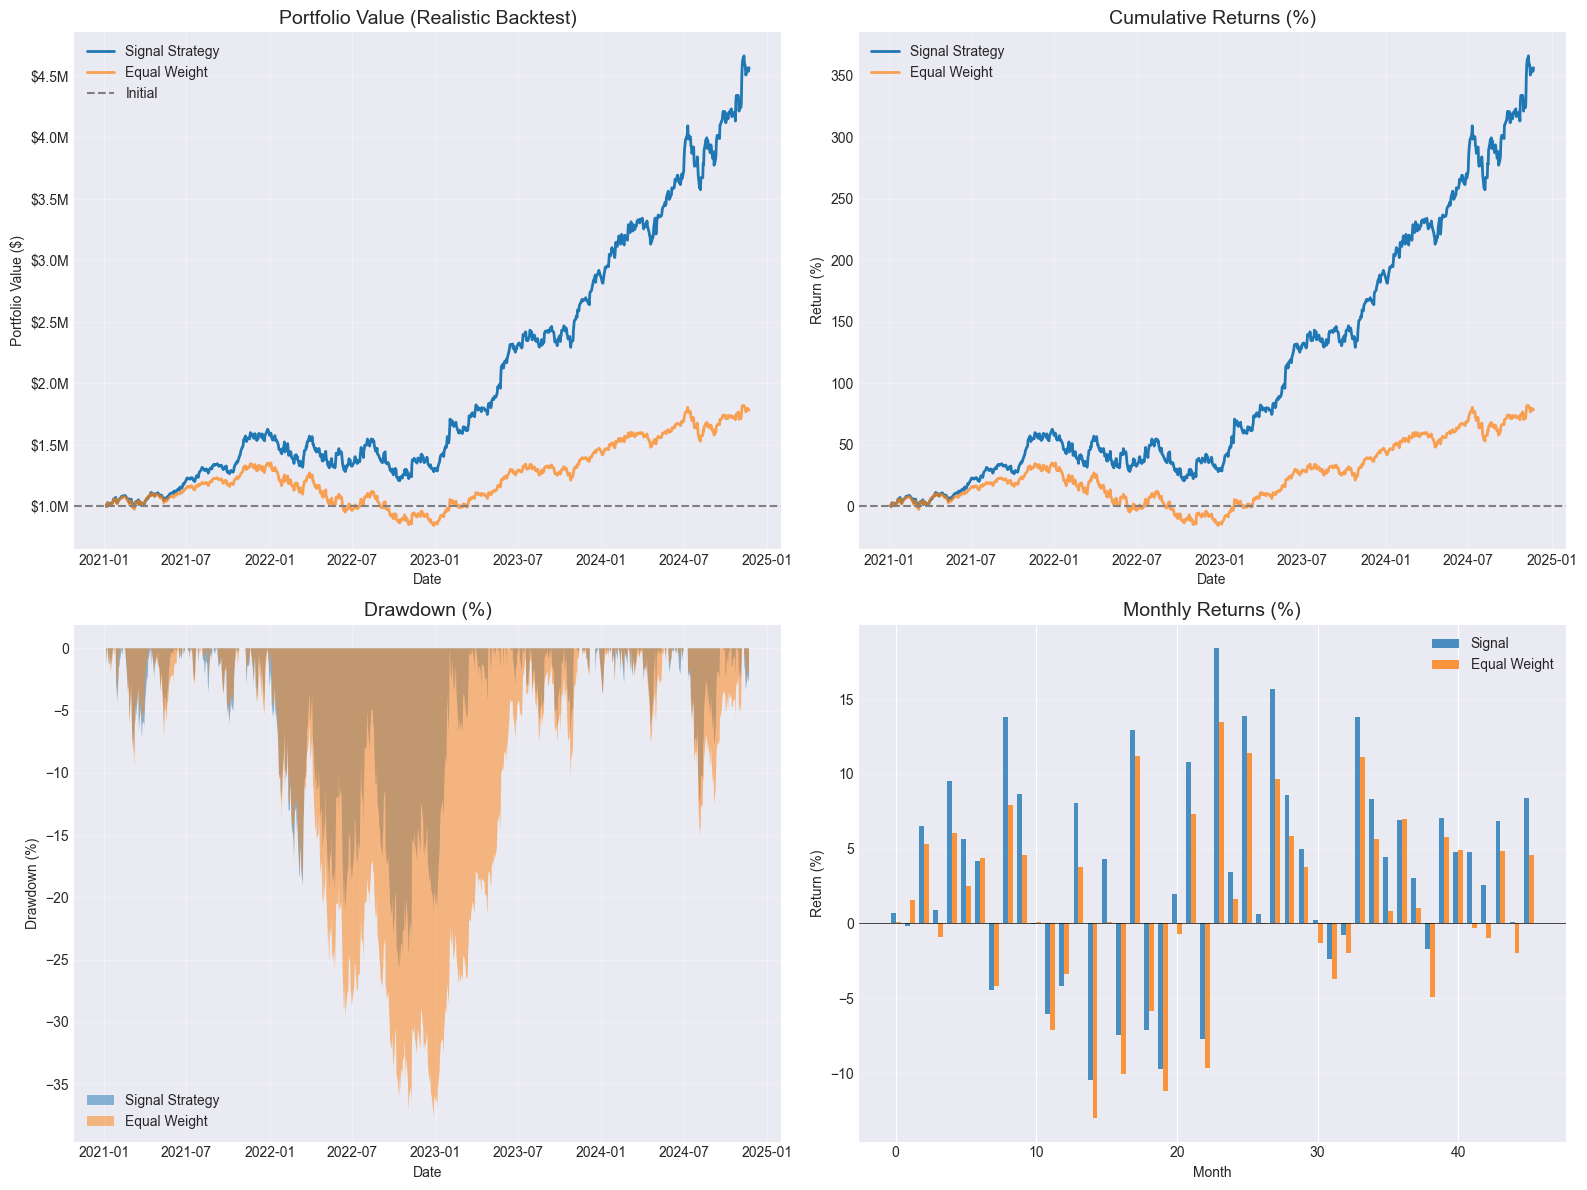


✅ Plot saved to c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\results\realistic_backtest\realistic_backtest_results.png


In [21]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Portfolio Value
ax1 = axes[0, 0]
ax1.plot(signal_results.index, signal_results['portfolio_value'], 
         label='Signal Strategy', linewidth=2)
ax1.plot(equal_results.index, equal_results['portfolio_value'], 
         label='Equal Weight', linewidth=2, alpha=0.7)
ax1.axhline(y=CONFIG['initial_capital'], color='gray', linestyle='--', label='Initial')
ax1.set_title('Portfolio Value (Realistic Backtest)', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Value ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

# Cumulative Returns
ax2 = axes[0, 1]
sig_cumret = (signal_results['portfolio_value'] / CONFIG['initial_capital'] - 1) * 100
eq_cumret = (equal_results['portfolio_value'] / CONFIG['initial_capital'] - 1) * 100
ax2.plot(signal_results.index, sig_cumret, label='Signal Strategy', linewidth=2)
ax2.plot(equal_results.index, eq_cumret, label='Equal Weight', linewidth=2, alpha=0.7)
ax2.axhline(y=0, color='gray', linestyle='--')
ax2.set_title('Cumulative Returns (%)', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Return (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Drawdown
ax3 = axes[1, 0]
sig_peak = signal_results['portfolio_value'].expanding().max()
sig_dd = (sig_peak - signal_results['portfolio_value']) / sig_peak * 100
eq_peak = equal_results['portfolio_value'].expanding().max()
eq_dd = (eq_peak - equal_results['portfolio_value']) / eq_peak * 100
ax3.fill_between(signal_results.index, 0, -sig_dd, alpha=0.5, label='Signal Strategy')
ax3.fill_between(equal_results.index, 0, -eq_dd, alpha=0.5, label='Equal Weight')
ax3.set_title('Drawdown (%)', fontsize=14)
ax3.set_xlabel('Date')
ax3.set_ylabel('Drawdown (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Monthly Returns Comparison
ax4 = axes[1, 1]
sig_monthly = signal_results['portfolio_value'].resample('M').last().pct_change().dropna()
eq_monthly = equal_results['portfolio_value'].resample('M').last().pct_change().dropna()
x = np.arange(len(sig_monthly))
width = 0.35
ax4.bar(x - width/2, sig_monthly * 100, width, label='Signal', alpha=0.8)
ax4.bar(x + width/2, eq_monthly * 100, width, label='Equal Weight', alpha=0.8)
ax4.axhline(y=0, color='black', linewidth=0.5)
ax4.set_title('Monthly Returns (%)', fontsize=14)
ax4.set_xlabel('Month')
ax4.set_ylabel('Return (%)')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'realistic_backtest_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Plot saved to {RESULTS_DIR / 'realistic_backtest_results.png'}")

## 5. Compare with Original (Flawed) Results

In [22]:
print("\n" + "="*70)
print("COMPARISON: Original vs Realistic Backtest")
print("="*70)

print("\n❌ ORIGINAL (FLAWED) RESULTS:")
print("   - RL Agent Return: 912.66%")
print("   - Equal Weight Return: 713.63%")
print("   - Sharpe Ratio: 7.64")
print("   ")
print("   Issues:")
print("   1. 5-day returns compounded DAILY (massive amplification)")
print("   2. OOS predictions overlapped with training data")
print("   3. Unrealistic 0.1% transaction costs")
print("   4. No slippage or market impact")

print("\n✅ REALISTIC RESULTS:")
print(f"   - Signal Strategy Return: {signal_metrics['total_return']*100:.2f}%")
print(f"   - Equal Weight Return: {equal_metrics['total_return']*100:.2f}%")
print(f"   - Signal Sharpe Ratio: {signal_metrics['sharpe_ratio']:.4f}")
print(f"   - Equal Weight Sharpe: {equal_metrics['sharpe_ratio']:.4f}")
print("   ")
print("   Fixes Applied:")
print("   1. Rebalance every 5 days (matching prediction horizon)")
print("   2. TRUE out-of-sample only (2021+)")
print("   3. Realistic 0.5% transaction costs")
print("   4. 0.2% slippage/market impact")

print("\n" + "-"*70)
alpha = signal_metrics['total_return'] - equal_metrics['total_return']
print(f"\n📊 ALPHA (Signal vs Benchmark): {alpha*100:+.2f}%")
print(f"   Annualized Alpha: {(signal_metrics['annual_return'] - equal_metrics['annual_return'])*100:+.2f}%")


COMPARISON: Original vs Realistic Backtest

❌ ORIGINAL (FLAWED) RESULTS:
   - RL Agent Return: 912.66%
   - Equal Weight Return: 713.63%
   - Sharpe Ratio: 7.64
   
   Issues:
   1. 5-day returns compounded DAILY (massive amplification)
   2. OOS predictions overlapped with training data
   3. Unrealistic 0.1% transaction costs
   4. No slippage or market impact

✅ REALISTIC RESULTS:
   - Signal Strategy Return: 353.16%
   - Equal Weight Return: 77.00%
   - Signal Sharpe Ratio: 1.9300
   - Equal Weight Sharpe: 0.6300
   
   Fixes Applied:
   1. Rebalance every 5 days (matching prediction horizon)
   2. TRUE out-of-sample only (2021+)
   3. Realistic 0.5% transaction costs
   4. 0.2% slippage/market impact

----------------------------------------------------------------------

📊 ALPHA (Signal vs Benchmark): +276.16%
   Annualized Alpha: +31.71%


In [23]:
# Save results
import json

results_summary = {
    'config': CONFIG,
    'signal_metrics': signal_metrics,
    'equal_metrics': equal_metrics,
    'alpha': signal_metrics['total_return'] - equal_metrics['total_return'],
    'timestamp': datetime.now().isoformat(),
    'note': 'Realistic backtest with proper methodology'
}

with open(RESULTS_DIR / 'realistic_results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)

# Save equity curves
equity_df = pd.DataFrame({
    'signal_strategy': signal_results['portfolio_value'],
    'equal_weight': equal_results['portfolio_value']
})
equity_df.to_csv(RESULTS_DIR / 'equity_curves.csv')

print(f"✅ Results saved to {RESULTS_DIR}")

✅ Results saved to c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\results\realistic_backtest


## 6. Conclusion

In [ ]:
print("\n" + "="*70)
print("🎯 FINAL ASSESSMENT")
print("="*70)

if signal_metrics['sharpe_ratio'] > equal_metrics['sharpe_ratio']:
    print("\n✅ The signal strategy OUTPERFORMS equal weight!")
    print(f"   Sharpe improvement: {signal_metrics['sharpe_ratio'] - equal_metrics['sharpe_ratio']:.4f}")
else:
    print("\n⚠️ The signal strategy UNDERPERFORMS equal weight.")
    print("   The XGBoost predictions do not add value after costs.")

print("\n📝 Key Takeaways:")
print(f"   1. Realistic annual return: {signal_metrics['annual_return']*100:.1f}% (not 358%)")
print(f"   2. Realistic Sharpe ratio: {signal_metrics['sharpe_ratio']:.2f} (not 7.64)")
print(f"   3. Max drawdown: {signal_metrics['max_drawdown']*100:.1f}%")
print(f"   4. Total transaction costs: ${signal_metrics['total_costs']:,.0f}")

print("\n🔬 For production use:")
print("   - Paper trade for 3-6 months before real money")
print("   - Start with small position sizes")
print("   - Monitor actual vs backtested performance")
print("   - Account for additional real-world frictions")


🎯 FINAL ASSESSMENT

✅ The signal strategy OUTPERFORMS equal weight!
   Sharpe improvement: 1.2999

📝 Key Takeaways:
   1. Realistic annual return: 47.5% (not 358%)
   2. Realistic Sharpe ratio: 1.93 (not 7.64)
   3. Max drawdown: 25.8%
   4. Total transaction costs: $1,169,775

🔬 For production use:
   - Paper trade for 3-6 months before real money
   - Start with small position sizes
   - Monitor actual vs backtested performance
   - Account for additional real-world frictions


: 